In [28]:
from lxml import etree
import re
import math
import numpy as np
import pandas as pd
from pprint import pprint
from time import time
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
%matplotlib inline

In [2]:
class Text(BaseEstimator, TransformerMixin): 
    def __init__(self, lenMin=2000, lenMax=10000, chunks=False): 
        self.lenMin = lenMin
        self.lenMax = lenMax
        self.chunks=chunks
        
    def fit(self, *_):
        print('heyo! fitting')
        return self

    def transform(self, filename): 
        print('heyo! transforming')
        lenMin, lenMax = self.lenMin, self.lenMax
        self.tree = etree.parse(filename)
        self.allSaidElems = self.tree.findall('.//said[@who]')
        # Only get those in our length range
        self.saidElems = [elem for elem in self.allSaidElems if len(elem.text)>lenMin and len(elem.text)<lenMax]
        self.allChars = [elem.attrib['who'] for elem in self.saidElems]
        self.chars = list(set(self.allChars))
        self.labeledText = [(elem.attrib['who'], elem.text) for elem in self.saidElems]
        self.labeledText = [(item[0], self.clean(item[1])) for item in self.labeledText]
        self.labels = [item[0] for item in self.labeledText]
        charDict = {'Bernard': 0, 'Louis': 1, 'Neville': 2,
                'Rhoda': 3, 'Jinny': 4, 'Susan': 5}
        self.numericLabels = [charDict[label] for label in self.labels]
        self.allText = [item[1] for item in self.labeledText]
        self.charDict = self.makeCharDict()
        self.charChunks, self.charChunksLabels = self.makeCharChunks()
        if self.chunks: 
            self.allText = self.charChunks
            self.labels = self.charChunksLabels
            self.numericLabels = [charDict[label.split('-')[0]] for label in self.labels]
        self.lengths = [len(item) for item in self.allText]
        return self.allText
        
    def makeCharDict(self): 
        """ Make a dictionary of each character's total speech. """
        # Initialize empty dictionary. 
        charDict = {char: "" for char in self.chars}
        for elem in self.allSaidElems: 
            charDict[elem.attrib['who']]+=self.clean(elem.text)
        return charDict
            
    def makeCharChunks(self, n=2): 
        """ Make a list of chunks of character speech. """
        charChunks = []
        charChunksLabels = []
        for char, text in self.charDict.items(): 
            chunks = self.sliceText(text)
            for i, chunk in enumerate(chunks): 
                charChunks.append(chunk)
                charChunksLabels.append(char + '-%s' % i)
        return charChunks, charChunksLabels
        
    def sliceText(self, text, size=8000):
        parts = []
        while len(text) > size: 
            part = text[:size]
            text = text[size:]
            parts.append(part)
        return parts

    def clean(self, utterance): 
        """ 
        Cleans utterances. 
        """
        # Remove "said Bernard," etc. 
        charRegex = "said (%s)" % '|'.join(self.chars)
        out = re.sub(charRegex, '', utterance)
       
        # Remove quotation marks. 
        out = re.sub('[“”"]', '', out)
        
        # Remove line breaks. 
        out = re.sub('\n', ' ', out)
        return out

In [3]:
# Code adapted from http://stackoverflow.com/a/28384887/584121
class DenseTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self): 
        return

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [6]:
def verboseGridSearch(pipeline, parameters, docs, labels): 
    scorer = metrics.make_scorer(metrics.adjusted_rand_score)    
    grid_search = GridSearchCV(pipeline, parameters, scoring=scorer, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(docs, labels)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

heyo! fitting
heyo! transforming


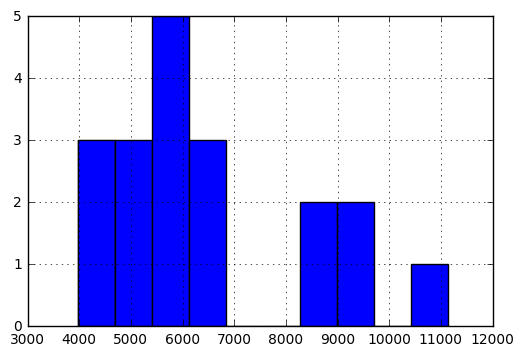

In [18]:
text = Text(lenMin=4000, lenMax=20000).fit()
docs = text.transform('waves-tei.xml')
labels = text.numericLabels
pd.Series([len(doc) for doc in docs]).hist()

In [19]:
len(docs), len(labels)

(19, 19)

# Test 1

In [20]:
pipeline = Pipeline([  
#                          ('text', Text()), 
                         ('tfidf', TfidfVectorizer()),
                         ('todense', DenseTransformer()),
                         ('reduce', PCA()),
                         ('bgm', BayesianGaussianMixture()),
                        ])

In [25]:
parameters = {  
#     'text__lenMin': (2000, 300
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.3, 0.4, 1.0),
    'tfidf__max_features': (200, 500, 2000, 20000, None), 
    'reduce': [PCA(), TruncatedSVD()],
    'reduce__n_components': (2, 5, 25, 30),
    'bgm__n_components': (6, 8, 10)
             }

In [26]:
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'reduce', 'bgm']
parameters:
{'bgm__n_components': (6, 8, 10),
 'reduce': [PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
            TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)],
 'reduce__n_components': (2, 5, 25, 30),
 'tfidf__max_df': (0.3, 0.4, 1.0),
 'tfidf__max_features': (200, 500, 2000, 20000, None)}
Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.6s


done in 59.983s

Best score: 0.329
Best parameters set:
	bgm__n_components: 10
	reduce: PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
	reduce__n_components: 5
	tfidf__max_df: 0.4
	tfidf__max_features: 500


[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   59.7s finished


# Test 2

In [27]:
parameters = {  
#     'text__lenMin': (2000, 300
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.3, 0.4, 1.0),
    'tfidf__max_features': (200, 500, 2000, 20000, None), 
    'reduce': [PCA(), TruncatedSVD()],
    'reduce__n_components': (2, 5, 25, 30),
    'bgm': [BayesianGaussianMixture(), GaussianMixture()]
    'bgm__n_components': (6, 8, 10)
             }

In [26]:
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'reduce', 'bgm']
parameters:
{'bgm__n_components': (6, 8, 10),
 'reduce': [PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
            TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)],
 'reduce__n_components': (2, 5, 25, 30),
 'tfidf__max_df': (0.3, 0.4, 1.0),
 'tfidf__max_features': (200, 500, 2000, 20000, None)}
Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.6s


done in 59.983s

Best score: 0.329
Best parameters set:
	bgm__n_components: 10
	reduce: PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
	reduce__n_components: 5
	tfidf__max_df: 0.4
	tfidf__max_features: 500


[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   59.7s finished


# Test 3

In [31]:
parameters = {  
#     'text__lenMin': (2000, 300
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.3, 0.4, 1.0),
    'tfidf__max_features': (200, 500, 2000, 20000, None), 
    'reduce': [PCA(), TruncatedSVD()],
    'reduce__n_components': (2, 5, 25, 30),
    'bgm': [BayesianGaussianMixture(), GaussianMixture()],
    'bgm__n_components': (6, 8, 10)
             }
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'reduce', 'bgm']
parameters:
{'bgm': [BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=100, mean_precision_prior=None, mean_prior=None,
            n_components=1, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process'),
         GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)],
 'bgm__n_components': (6, 8, 10),
 'reduce': [PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.4min


done in 113.660s

Best score: 0.397
Best parameters set:
	bgm: GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
	bgm__n_components: 10
	reduce: PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
	reduce__n_components: 5
	tfidf__max_df: 0.3
	tfidf__max_features: 200


[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.9min finished


# Test 4

In [32]:
pipeline = Pipeline([  
#                          ('text', Text()), 
                         ('tfidf', TfidfVectorizer()),
                         ('todense', DenseTransformer()),
                         ('reduce', PCA()),
#                          ('bgm', BayesianGaussianMixture()),
                         ('kmeans', KMeans(n_clusters=6))
                        ])

In [34]:
parameters = {  
#     'text__lenMin': (2000, 300
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.3, 0.4, 1.0),
    'tfidf__max_features': (200, 500, 2000, 20000, None), 
    'reduce': [PCA(), TruncatedSVD()],
    'reduce__n_components': (2, 5, 25, 30),
#     'bgm': [BayesianGaussianMixture(), GaussianMixture()],
#     'bgm__n_components': (6, 8, 10)
             }
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'reduce', 'kmeans']
parameters:
{'reduce': [PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
            TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)],
 'reduce__n_components': (2, 5, 25, 30),
 'tfidf__max_df': (0.3, 0.4, 1.0),
 'tfidf__max_features': (200, 500, 2000, 20000, None)}
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s


done in 15.326s

Best score: 0.300
Best parameters set:
	reduce: TruncatedSVD(algorithm='randomized', n_components=30, n_iter=5,
       random_state=None, tol=0.0)
	reduce__n_components: 30
	tfidf__max_df: 0.3
	tfidf__max_features: 2000


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   15.0s finished


# Test 5


In [36]:
pipeline = Pipeline([  
#                          ('text', Text()), 
                         ('tfidf', TfidfVectorizer()),
                         ('todense', DenseTransformer()),
                         ('reduce', PCA()),
                         ('bgm', BayesianGaussianMixture()),
#                          ('kmeans', KMeans(n_clusters=6))
                        ])

In [37]:
parameters = {  
#     'text__lenMin': (2000, 300
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.3, 0.4, 1.0),
    'tfidf__max_features': (100, 200, 500, 2000, None), 
    'reduce': [PCA(), TruncatedSVD()],
    'reduce__n_components': (2, 5, 25, 30, 50),
    'bgm': [BayesianGaussianMixture(), GaussianMixture()],
    'bgm__n_components': (2, 6, 8, 10)
             }
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'reduce', 'bgm']
parameters:
{'bgm': [BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=100, mean_precision_prior=None, mean_prior=None,
            n_components=1, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process'),
         GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)],
 'bgm__n_components': (2, 6, 8, 10),
 'reduce': [PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  2.9min


done in 176.395s

Best score: 0.397
Best parameters set:
	bgm: GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
	bgm__n_components: 10
	reduce: PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
	reduce__n_components: 5
	tfidf__max_df: 0.3
	tfidf__max_features: 200


[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.9min finished
